# DAMASK tutorial for tensile test with experimental data

- creating necessary inputs for damask
- defining the elastoplastic model (with powerlaw) from experiental data for tensile test
- runing the damask jobs

here more option is given to the user to select from damask python package itself.

Author: Yang Bai

Date  : 20.10.2022

## Importing libraries and creatign Project

In [1]:
from pyiron_continuum import Project
from damask import Rotation # this will be used in material configuration

2022-10-24 12:37:57,073 - pyiron_log - WARNING - Configuration file may be read by others - check permissions to secure credential information!


In [1]:
import requests
import json
import pandas as pd

### create a 'project' to manage all the configurations for a tensile test

In [2]:
pr = Project('tensile')
pr.remove_jobs(silently=True) # automatically delete the existing project folder

  0%|          | 0/1 [00:00<?, ?it/s]

### Creating the Damask job

In [3]:
job = pr.create.job.DAMASK('damask_job')

#### for a damask job, one needs:
- geometry information(i.e., the mesh)
- material configuration(material.yaml)
- boundary conditions(i.e., loading.yaml)

### For material configuration
#### for elastoplastic material

# Here the parameters are taken from H340LAD(IWM)
## Youngs modulus=187170e6 Pa
## poisson ratio=0.2

# Get Youngs modulus from DSMS

In [3]:
# query = """
# select ?MethodConcept (STR(?Number) as ?Value) where {
#   ?MethodConcept <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.semanticweb.org/stahl-digital#ModulusOfElasticity> .
#   ?DataEntity owl:sameAs ?MethodConcept .
#   ?DataEntity <http://emmo.info/emmo/middle/metrology#EMMO_8ef3cd6d_ae58_4a8d_9fc0_ad8f49015cd0> ?Numeric .
#   ?Numeric <http://emmo.info/emmo/middle/math#EMMO_faf79f53_749d_40b2_807c_d34244c192f4> ?Number .
# }
# limit 100
# """

# resp = requests.post(url="https://127.0.0.1/api/knowledge/sparql",
# json={"query":query},
# verify=False)

# data = json.loads(resp.text)

# df = pd.read_json(data['sparql'], orient='index')

# emodule_from_query = float(eval(df.loc[0,"Value"]))
# emodule_from_query

/home/paul/anaconda3/envs/data2rdf/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


187169.84

In [4]:
E=187169.84;nu=0.2
# E=emodule_from_query;nu=0.2
# for bulk modulus and shear modulus
K=E/(3*(1-2*nu))
G=0.5*E/(1+nu)
C11=K+4*G/3.0
C12=K-2*G/3.0
C44=G

elasticity = pr.continuum.damask.Elasticity(type= 'Hooke', C_11= C11,
                                   C_12= C12, C_44=C44)

# for plastic deformation, we use the power law
plasticity = pr.continuum.damask.Plasticity(type='phenopowerlaw',
                                            N_sl=[12], a_sl=2.25,
                                            atol_xi=1.0, dot_gamma_0_sl=0.001,
                                            h_0_sl_sl=132e6, h_sl_sl=[1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                                            n_sl=20, output=['xi_sl'],
                                            xi_0_sl=[136e6], xi_inf_sl=[378e6])


#### for material configuration, you need
- phase
- roation
- homogenization

In [5]:
grains, grids = 8,8 # for the number of grains and grids

phase = pr.continuum.damask.Phase(composition='H340LAD', lattice= 'cF',
                         output_list=['F', 'P', 'F_e', 'F_p', 'L_p', 'O'],
                         elasticity=elasticity,plasticity=plasticity)
rotation = pr.continuum.damask.Rotation(Rotation.from_random, grains)
homogenization = pr.continuum.damask.Homogenization(method='SX', 
                                                     parameters={'N_constituents': 1,
                                                                 "mechanical": {"type": "pass"}})
# now you can define your material.yaml configuration
material = pr.continuum.damask.Material([rotation],['H340LAD'], phase, homogenization)
# now you can save your material to your job
job.material = material

## For geometry information
### the size of the sample is 5mmx5mmx5mm

In [6]:
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(box_size=5.0e-3, 
                                                         grid_dim=grids, 
                                                         num_grains=grains)
# save the geometry information to your job
job.grid = grid 

## Configure the boundary conditions

In [7]:
load_step =[{'mech_bc_dict':{'dot_F':[2.5e-3,0,0, 0,'x',0,  0,0,'x'],
                            'P':['x','x','x', 'x',0,'x',  'x','x',0]},
            'discretization':{'t': 50.,'N': 200},
            'additional': {'f_out': 5}
           }]
solver = job.list_solvers()[0] # choose the mechanis solver
job.loading = pr.continuum.damask.Loading(solver=solver, load_steps=load_step)

In [8]:
job.run() # running your job, if you want the parallelization you can modify your 'pyiron/damask/bin/run_damask_3.0.0.sh file'

The job damask_job was saved and received the ID: 1


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


In [9]:
print(job.output.strain_von_Mises)
print(job.output.stress_von_Mises)

[0.         0.0028138  0.00616615 0.00958617 0.01301516 0.01644042
 0.01985807 0.02326718 0.026667   0.03005702 0.0334371  0.03680665
 0.04016577 0.04351406 0.04685161 0.05017824 0.05349396 0.05679874
 0.06009249 0.06337534 0.06664713 0.06990802 0.07315793 0.076397
 0.07962517 0.08284254 0.08604917 0.08924522 0.09243073 0.09560581
 0.0987706  0.10192521 0.10506959 0.10820388 0.11132835 0.11444291
 0.11754757 0.1206425  0.12372774 0.12680329 0.12986927]
[2.51328528e-05 3.47263213e+08 3.92760500e+08 4.09333687e+08
 4.17367969e+08 4.22194728e+08 4.25448297e+08 4.27932276e+08
 4.29992501e+08 4.31825846e+08 4.33525994e+08 4.35096217e+08
 4.36576370e+08 4.37999212e+08 4.39401780e+08 4.40755907e+08
 4.42095183e+08 4.43375913e+08 4.44655664e+08 4.45887977e+08
 4.47100092e+08 4.48315901e+08 4.49503374e+08 4.50657973e+08
 4.51836960e+08 4.52954001e+08 4.54073166e+08 4.55161563e+08
 4.56272626e+08 4.57326662e+08 4.58382497e+08 4.59413935e+08
 4.60440594e+08 4.61454004e+08 4.62466569e+08 4.6345165

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='$\\varepsilon_{vM}$', ylabel='$\\sigma_{vM}$ (Pa)'>)

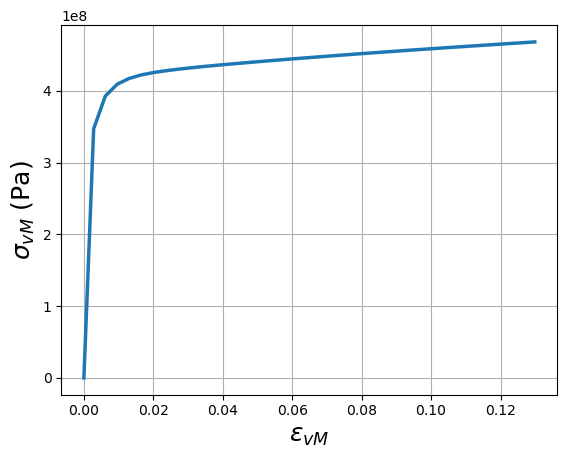

In [10]:
job.plot_stress_strain(von_mises=True)# results from damask simulation

# Comparison with experimental data from H340LAD(IWM)
## The experimental data is taken from 'AFZ1-Fz-S1Q.xlsm', the stress and strain are exported to 'Data.csv'

# Get Strain/Stress from DSMS

In [4]:
# query = """
# select ?Measurement ?Measurement_Label ?DataArray ?url ?ProjectName where {
  
#   { ?Measurement <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.semanticweb.org/stahl-digital#EngineeringStrain> } 
#   UNION 
#   { ?Measurement <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.semanticweb.org/stahl-digital#EngineeringStress> } 
#   ?DataArray owl:sameAs ?Measurement .
#   ?DataArray <http://www.w3.org/ns/dcat#downloadURL> ?url .
#   ?DataSet <http://emmo.info/datamodel#composition> ?DataArray.
#   ?DataSet <http://emmo.info/datamodel#composition> ?MetaData .
#   ?MetaData <http://emmo.info/emmo/middle/perceptual#EMMO_23b579e1_8088_45b5_9975_064014026c42> ?ProjectName .
#   ?MetaData owl:sameAs ?MetaDataGeneric .
#   ?MetaDataGeneric <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://www.semanticweb.org/stahl-digital#ProjectName> .
#   ?Measurement rdfs:label ?Measurement_Label . 
# }
# limit 100
# """

# resp = requests.post(url="https://127.0.0.1/api/knowledge/sparql",
# json={"query":query},
# verify=False)

# data = json.loads(resp.text)

# df = pd.read_json(data['sparql'], orient='index')
# df = df.drop_duplicates(subset = "Measurement_Label")

/home/paul/anaconda3/envs/data2rdf/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,Measurement,Measurement_Label,DataArray,url,ProjectName
0,<https://stahldigital.materials-data.space/2a0...,"""EngineeringStrain""",<https://stahldigital.materials-data.space/2a0...,"""https://127.0.0.1/api/knowledge/data_api/2a0f...","""INSTABILITAET""^^<http://www.w3.org/2001/XMLSc..."
2,<https://stahldigital.materials-data.space/2a0...,"""EngineeringStress""",<https://stahldigital.materials-data.space/2a0...,"""https://127.0.0.1/api/knowledge/data_api/2a0f...","""INSTABILITAET""^^<http://www.w3.org/2001/XMLSc..."


In [5]:
# tensile_test_data = {}
# for row_id, row in df.iterrows():
    
#     label = eval(row["Measurement_Label"])
#     url = eval(row["url"])
#     resp = requests.get(url=url, verify=False)
#     data = json.loads(resp.text)
#     array = data['array']

#     tensile_test_data[label] = array

# tensile_test_data

/home/paul/anaconda3/envs/data2rdf/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/paul/anaconda3/envs/data2rdf/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


{'EngineeringStrain': [6.27293344606431e-05,
  0.0001442293344606431,
  0.00022272933446064312,
  0.0003072293344606431,
  0.0004102293344606431,
  0.0004957293344606431,
  0.0006092293344606432,
  0.0007152293344606432,
  0.0008202293344606431,
  0.0009097293344606432,
  0.001025229334460643,
  0.0011207293344606432,
  0.001240729334460643,
  0.001338729334460643,
  0.001452729334460643,
  0.001586229334460643,
  0.0017107293344606432,
  0.0018542293344606432,
  0.002023729334460643,
  0.002235729334460643,
  0.0024672293344606432,
  0.0027482293344606432,
  0.003009229334460643,
  0.003351729334460643,
  0.003929229334460643,
  0.004839729334460642,
  0.005664229334460643,
  0.006667729334460642,
  0.0076412293344606435,
  0.008620229334460643,
  0.009652729334460642,
  0.010714729334460642,
  0.011733229334460643,
  0.012739729334460641,
  0.013733729334460643,
  0.01468172933446064,
  0.01562822933446064,
  0.016581729334460643,
  0.017532729334460644,
  0.018366729334460645,
  0.0

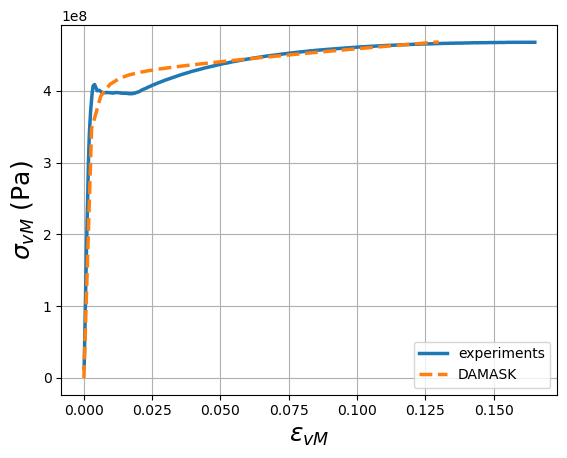

In [11]:
# job.add_experimental_stress_strain(stress = tensile_test_data["EngineeringStress"],
# strain = tensile_test_data["EngineeringStrain"])